# Import Libraries

In [4]:
from sklearn.externals import joblib
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

## Load Data Dump 

In [5]:
from sagemaker import get_execution_role
import boto3
from s3fs.core import S3FileSystem
role = get_execution_role()
bucket='instacartresearchsymposium'
data_key = 'ReorderProbability_DataFrame_duplicates_removed'
#data_location = 's3://{}/{}'.format(bucket, data_key)
#s3 = boto3.client('s3')
#obj = s3.get_object(Bucket=bucket, Key=data_key)
s3 = S3FileSystem(anon=False)
dataDump = joblib.load(s3.open('{}/{}'.format(bucket, data_key), mode='rb'))
dataDump.head()

,OrderID,ProductID,reordered,UserID,UserTotalOrder,UserTotalProductOrder,UserProductTotalReordered,UserProductOrdersShare,UserMedianDaysSincePriorOrder
0,2,33120,True,202279,9,6,5.0,0.666667,27.0
1,2,28985,True,202279,9,5,4.0,0.555556,27.0
2,2,9327,False,202279,9,1,0.0,0.111111,27.0
3,2,45918,True,202279,9,5,4.0,0.555556,27.0
4,2,30035,False,202279,9,3,2.0,0.333333,27.0


In [6]:
dataDump.describe()

,OrderID,ProductID,UserID,UserTotalOrder,UserTotalProductOrder,UserProductTotalReordered,UserProductOrdersShare,UserMedianDaysSincePriorOrder
count,1.386375e+07,1.386375e+07,1.386375e+07,1.386375e+07,1.386375e+07,1.386375e+07,1.386375e+07,1.386375e+07
mean,1.497096e+06,2.551068e+04,1.030158e+05,2.582566e+01,2.439392e+00,1.439392e+00,1.425333e-01,1.217367e+01
std,1.013340e+06,1.422548e+04,5.943946e+04,2.213607e+01,3.548338e+00,3.548338e+00,1.499583e-01,8.003374e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00
25%,5.814342e+05,1.329200e+04,5.160325e+04,9.000000e+00,1.000000e+00,0.000000e+00,4.444444e-02,6.500000e+00
50%,1.400979e+06,2.563800e+04,1.027330e+05,1.800000e+01,1.000000e+00,0.000000e+00,9.090909e-02,9.000000e+00
75%,2.356795e+06,3.815400e+04,1.544780e+05,3.500000e+01,2.000000e+00,1.000000e+00,1.875000e-01,1.600000e+01
max,3.421083e+06,4.968800e+04,2.062090e+05,1.000000e+02,1.000000e+02,9.900000e+01,1.000000e+00,3.000000e+01


# Checking Outliers

In [7]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1
    print("Q1:",q1,"Q3:" ,q3,"IQR",iqr)
    lowerBound = q1 - (iqr * 1.5)
    higherBound = q3 + (iqr * 1.5)
    print("Lower Bound:",lowerBound, "Higher Bound:",higherBound)
    outliers = df_in.loc[(df_in[col_name] < lowerBound) | (df_in[col_name] > higherBound)]
    print("Amount of Outliers:",len(outliers))
    print("Percentage:", len(outliers)/len(df_in))
    percentage = len(outliers)/len(df_in)
    if percentage < 0.05:
        df_in = df_in.loc[(df_in[col_name] > lowerBound) & (df_in[col_name] < higherBound), :].copy()
        print("Dropped")
        return df_in
    else:
        mean = df_in[col_name].mean()
        df_in.loc[(df_in[col_name] < lowerBound) | (df_in[col_name] > higherBound), col_name] = mean
        print("Imputed with mean:", mean)
        return df_in

## UserTotalOrder

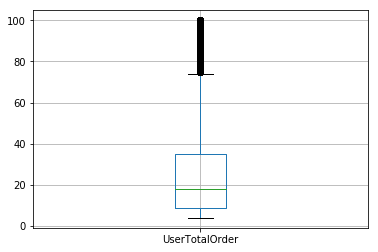

In [8]:
dataDump.boxplot(column='UserTotalOrder')

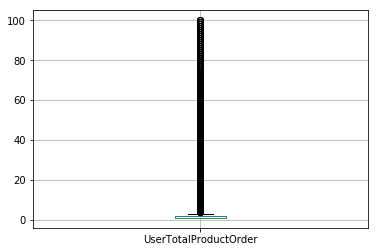

In [9]:
dataDump.boxplot(column='UserTotalProductOrder')

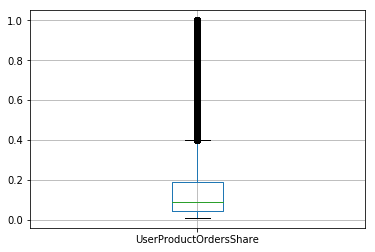

In [10]:
dataDump.boxplot(column='UserProductOrdersShare')

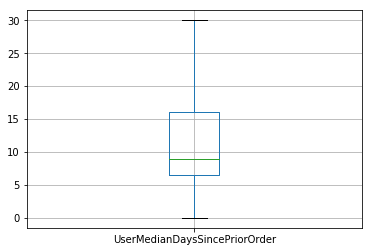

In [11]:
dataDump.boxplot(column='UserMedianDaysSincePriorOrder')

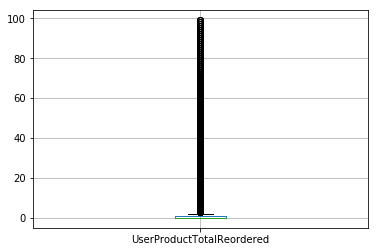

In [12]:
dataDump.boxplot(column='UserProductTotalReordered')

In [13]:
dataDump = remove_outlier(dataDump, "UserTotalOrder")

Q1: 9.0 Q3: 35.0 IQR 26.0
Lower Bound: -30.0 Higher Bound: 74.0
Amount of Outliers: 685859
Percentage: 0.04947140549170477
Dropped


In [14]:
#dataDump = remove_outlier(dataDump, "UserMedianDaysSincePriorOrder")

In [15]:
dataDump = remove_outlier(dataDump, "UserProductOrdersShare")

Q1: 0.047619047619047616 Q3: 0.2 IQR 0.1523809523809524
Lower Bound: -0.18095238095238098 Higher Bound: 0.4285714285714286
Amount of Outliers: 770922
Percentage: 0.05863222951113418
Imputed with mean: 0.14765878928375165


In [16]:
dataDump = remove_outlier(dataDump, "UserMedianDaysSincePriorOrder")

Q1: 7.0 Q3: 17.0 IQR 10.0
Lower Bound: -8.0 Higher Bound: 32.0
Amount of Outliers: 0
Percentage: 0.0
Dropped


In [17]:
#dataDump = remove_outlier(dataDump, "UserProductTotalReordered")

In [18]:
dataDump.reset_index(drop= True, inplace = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f965d4fdac8>]],
      dtype=object)

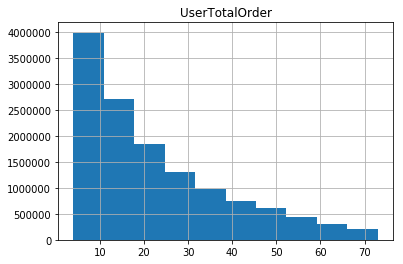

In [19]:
dataDump.hist(column= "UserTotalOrder")

In [20]:
def makeBins(df, bins, binLabels, column_name):
    df[column_name + "_bin"] = pd.cut(df[column_name], bins,labels = binLabels, include_lowest = True)
def getBins(df, column_name):
    df.hist(column= column_name)
    count, division = np.histogram(df[column_name])
    print("Count in Bins:", count, "\nBins:", division, "\nAmount of Bins:", len(division))

In [21]:
UserTotalOrderBinLabels = ["0-10", "11-20","21-30","31-40", "41-50", "51-60", "61-70", "71-80"]
UserTotalOrderBins = [0,10,20,30,40,50,60,70,80]
makeBins(dataDump,UserTotalOrderBins,UserTotalOrderBinLabels, "UserTotalOrder")
dataDump.head()

,OrderID,ProductID,reordered,UserID,UserTotalOrder,UserTotalProductOrder,UserProductTotalReordered,UserProductOrdersShare,UserMedianDaysSincePriorOrder,UserTotalOrder_bin
0,2,33120,True,202279,9,6,5.0,0.147659,27.0,0-10
1,2,28985,True,202279,9,5,4.0,0.147659,27.0,0-10
2,2,9327,False,202279,9,1,0.0,0.111111,27.0,0-10
3,2,45918,True,202279,9,5,4.0,0.147659,27.0,0-10
4,2,30035,False,202279,9,3,2.0,0.333333,27.0,0-10


Count in Bins: [12500202   467443   113912    39791    15983     6956     2931      967
      199       50] 
Bins: [ 1.   7.9 14.8 21.7 28.6 35.5 42.4 49.3 56.2 63.1 70. ] 
Amount of Bins: 11


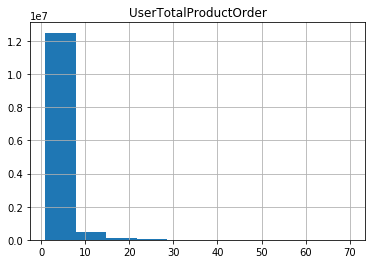

In [22]:
getBins(dataDump, "UserTotalProductOrder")

In [23]:
UserTotalProductOrderBinLabels = ["0-7", "8-14","15-21","22-28", "29-35", "36-42", "43-49", "50-56", "57-63", "64-70"]
UserTotalProductOrderBins = [0,7,14,21,28,35,42,49,56,63,70]
makeBins(dataDump,UserTotalProductOrderBins,UserTotalProductOrderBinLabels, "UserTotalProductOrder")
dataDump.head()

,OrderID,ProductID,reordered,UserID,UserTotalOrder,UserTotalProductOrder,UserProductTotalReordered,UserProductOrdersShare,UserMedianDaysSincePriorOrder,UserTotalOrder_bin,UserTotalProductOrder_bin
0,2,33120,True,202279,9,6,5.0,0.147659,27.0,0-10,0-7
1,2,28985,True,202279,9,5,4.0,0.147659,27.0,0-10,0-7
2,2,9327,False,202279,9,1,0.0,0.111111,27.0,0-10,0-7
3,2,45918,True,202279,9,5,4.0,0.147659,27.0,0-10,0-7
4,2,30035,False,202279,9,3,2.0,0.333333,27.0,0-10,0-7


Count in Bins: [3768001 2730884 1742019 2139496  892085  900246  312225  270978  149727
  242773] 
Bins: [0.01369863 0.05518591 0.09667319 0.13816047 0.17964775 0.22113503
 0.26262231 0.30410959 0.34559687 0.38708415 0.42857143] 
Amount of Bins: 11


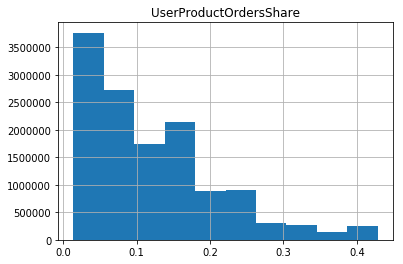

In [24]:
getBins(dataDump, "UserProductOrdersShare")

In [25]:
UserProductOrdersShareBinLabels = ["0-5%", "6-10%","11-15%","16-20%", "21-25%", "26-30%", "31-35%", "36-40%", "41-45%"]
UserProductOrdersShareBins = [0.0,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45]
makeBins(dataDump,UserProductOrdersShareBins,UserProductOrdersShareBinLabels, "UserProductOrdersShare")
dataDump.head()

,OrderID,ProductID,reordered,UserID,UserTotalOrder,UserTotalProductOrder,UserProductTotalReordered,UserProductOrdersShare,UserMedianDaysSincePriorOrder,UserTotalOrder_bin,UserTotalProductOrder_bin,UserProductOrdersShare_bin
0,2,33120,True,202279,9,6,5.0,0.147659,27.0,0-10,0-7,11-15%
1,2,28985,True,202279,9,5,4.0,0.147659,27.0,0-10,0-7,11-15%
2,2,9327,False,202279,9,1,0.0,0.111111,27.0,0-10,0-7,11-15%
3,2,45918,True,202279,9,5,4.0,0.147659,27.0,0-10,0-7,11-15%
4,2,30035,False,202279,9,3,2.0,0.333333,27.0,0-10,0-7,31-35%


Count in Bins: [  99744 1697976 4014979 1799173 1552446  921862  663169  577437  407629
 1414019] 
Bins: [ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27. 30.] 
Amount of Bins: 11


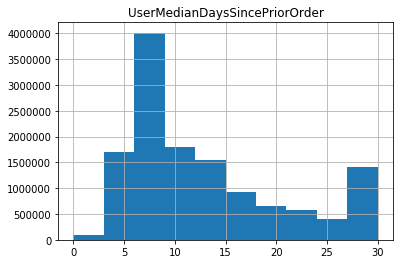

In [26]:
getBins(dataDump, "UserMedianDaysSincePriorOrder")

In [27]:
UserMedianDaysSincePriorOrderBinLabels = [ "0-3","4-6","7-9","10-12","13-15","16-18","19-21","22-24","25-27","28-30"] 
UserMedianDaysSincePriorOrderBins = [ 0,3,6,9,12,15,18,21,24,27,30] 
makeBins(dataDump,UserMedianDaysSincePriorOrderBins,UserMedianDaysSincePriorOrderBinLabels, "UserMedianDaysSincePriorOrder")
dataDump.head()

,OrderID,ProductID,reordered,UserID,UserTotalOrder,UserTotalProductOrder,UserProductTotalReordered,UserProductOrdersShare,UserMedianDaysSincePriorOrder,UserTotalOrder_bin,UserTotalProductOrder_bin,UserProductOrdersShare_bin,UserMedianDaysSincePriorOrder_bin
0,2,33120,True,202279,9,6,5.0,0.147659,27.0,0-10,0-7,11-15%,25-27
1,2,28985,True,202279,9,5,4.0,0.147659,27.0,0-10,0-7,11-15%,25-27
2,2,9327,False,202279,9,1,0.0,0.111111,27.0,0-10,0-7,11-15%,25-27
3,2,45918,True,202279,9,5,4.0,0.147659,27.0,0-10,0-7,11-15%,25-27
4,2,30035,False,202279,9,3,2.0,0.333333,27.0,0-10,0-7,31-35%,25-27


Count in Bins: [12500202   467443   113912    39791    15983     6956     2931      967
      199       50] 
Bins: [ 0.   6.9 13.8 20.7 27.6 34.5 41.4 48.3 55.2 62.1 69. ] 
Amount of Bins: 11


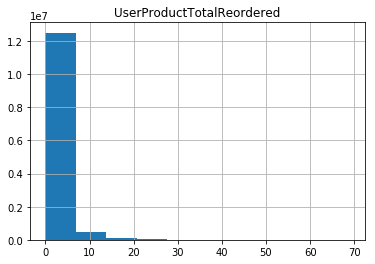

In [28]:
dataDump.fillna(value= {"UserProductTotalReordered" : 0}, inplace = True)
getBins(dataDump, "UserProductTotalReordered")

In [29]:
UserProductTotalReorderedBinLabels = ["0-7", "8-14","15-21","22-28", "29-35", "36-42", "43-49", "50-56", "57-63", "64-70"]
UserProductTotalReorderedBins = [0,7,14,21,28,35,42,49,56,63,70]
makeBins(dataDump,UserProductTotalReorderedBins,UserProductTotalReorderedBinLabels, "UserProductTotalReordered")
dataDump.head()

,OrderID,ProductID,reordered,UserID,UserTotalOrder,UserTotalProductOrder,UserProductTotalReordered,UserProductOrdersShare,UserMedianDaysSincePriorOrder,UserTotalOrder_bin,UserTotalProductOrder_bin,UserProductOrdersShare_bin,UserMedianDaysSincePriorOrder_bin,UserProductTotalReordered_bin
0,2,33120,True,202279,9,6,5.0,0.147659,27.0,0-10,0-7,11-15%,25-27,0-7
1,2,28985,True,202279,9,5,4.0,0.147659,27.0,0-10,0-7,11-15%,25-27,0-7
2,2,9327,False,202279,9,1,0.0,0.111111,27.0,0-10,0-7,11-15%,25-27,0-7
3,2,45918,True,202279,9,5,4.0,0.147659,27.0,0-10,0-7,11-15%,25-27,0-7
4,2,30035,False,202279,9,3,2.0,0.333333,27.0,0-10,0-7,31-35%,25-27,0-7


## Import Library 

In [30]:
from pandas.api.types import CategoricalDtype

In [31]:
def factorData(data,columns):
    for column in columns: 
        data[column] = data[column].astype('category')
        data[column + '_factors'] = data[column].cat.codes

In [32]:
columns = ['UserTotalOrder_bin', 'UserTotalProductOrder_bin', 'UserProductOrdersShare_bin'
           , 'UserMedianDaysSincePriorOrder_bin', 'UserProductTotalReordered_bin']

In [33]:
factorData(dataDump, columns)

In [34]:
#testing/training with only 5000 records due to scalability issues... 
# tempData = dataDump.head(5000).copy()

# Train/Test Split

In [35]:
#only takes first 5000 rows


In [36]:
trainData = dataDump[['UserProductTotalReordered_bin_factors', 'UserMedianDaysSincePriorOrder_bin_factors'
                    , 'UserProductOrdersShare_bin_factors', 'UserTotalProductOrder_bin_factors'
                     , 'UserTotalOrder_bin_factors', 'reordered']]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(trainData.drop(['reordered'], axis=1)
                                                   , trainData['reordered'], test_size=0.2, random_state=42)

# Random Forest Model
## Parameter Testing 

In [39]:
#determining how many trees to use for predictions (n_estimators) based on OOB score 
n_range = [30,50,100,200]
error_rates = []

for n in n_range:
    rf = RandomForestClassifier(n_estimators=n, n_jobs=-1, random_state=42, oob_score=True)
    rf.fit(X_train, y_train)
    oob_error = 1-rf.oob_score_
    error_rates.append(oob_error)
    print("Done")

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Done
Done
Done
Done


KeyboardInterrupt: 

In [40]:
error_rates

[0.14870953736219727,
 0.1487066853114729,
 0.1487425260822416,
 0.14879025039769467]

In [41]:
#fine tuning n_estimators
n_range = range(30,50)
error_rates = []
for n in n_range:
    rf = RandomForestClassifier(n_estimators=n, n_jobs=-1, random_state=42, oob_score=True)
    rf.fit(X_train, y_train)
    oob_error = 1-rf.oob_score_
    error_rates.append(oob_error)
    print("Done")

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Done


KeyboardInterrupt: 

In [37]:
error_rates

In [43]:
#n_estimators = 56
#max features
n_features = ['auto', 'sqrt', 'log2', 0.9, 0.2]
scores = []

for n in n_features:
    rf = RandomForestClassifier(n_estimators=56, random_state=42, max_features = n, oob_score=False)
    rf.fit(X_train, y_train)
    y_hat = rf.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_hat))

KeyboardInterrupt: 

In [45]:
#n_range = range(1, 50)
n_range = range(1,10)
scores = []

for n in n_range:
    rf = RandomForestClassifier(n_estimators=30, random_state=42, max_features = 'auto', min_samples_leaf=n, oob_score=False)
    rf.fit(X_train, y_train)
    y_hat = rf.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_hat))
    print(metrics.accuracy_score(y_test, y_hat))

0.8515477317262473
0.8515477317262473
0.8515477317262473
0.8515477317262473


KeyboardInterrupt: 

## Test performance of Finalized Random Forest Model

In [46]:
rf = RandomForestClassifier(n_estimators=30, random_state=42, max_features = 'auto', min_samples_leaf=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [47]:
rf.score(X_test, y_test) #this is the accuracy score of our random forest model with the arguments above 82.68% 

0.8515477317262473

# Logistic Regression
## Parameter Testing

In [71]:
#penalty
penalties = ['l1', 'l2']
scores = []

for p in penalties:
    lr = LogisticRegression(penalty=p, random_state=42)
    lr.fit(X_train, y_train)
    y_hat = lr.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_hat))

In [72]:
scores

[0.7826666666666666, 0.7806666666666666]

In [78]:
#C value
c_range = range(10,20)
scores = []

for c in c_range:
    lr = LogisticRegression(penalty='l1', C=c, random_state=42)
    lr.fit(X_train, y_train)
    y_hat = lr.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_hat))    

In [79]:
scores

[0.784,
 0.784,
 0.784,
 0.784,
 0.784,
 0.7833333333333333,
 0.7837777777777778,
 0.7837777777777778,
 0.7837777777777778,
 0.7837777777777778]

In [82]:
#solver algorithm
solver = ['liblinear', 'saga']
scores = []
for c in solver:
    lr = LogisticRegression(penalty='l1', C=10, random_state=42, solver = c)
    lr.fit(X_train, y_train)
    y_hat = lr.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_hat))    

C:\Users\cnguyen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [84]:
scores

[0.784, 0.794]

## Test performance of Finalized Logistic Regression Model

In [85]:
lr = LogisticRegression(penalty='l1', C=10, random_state=42, solver = 'saga', n_jobs=-1)

In [86]:
lr.fit(X_train, y_train)

C:\Users\cnguyen\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=42, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [87]:
lr.score(X_test, y_test)

0.794

# GaussianNB

In [89]:
gnb=GaussianNB()

In [90]:
gnb.fit(X_train, y_train)

GaussianNB(priors=None)

In [92]:
gnb.score(X_test, y_test)

0.7335555555555555

# Predict Probability of Reordering

In [26]:
rf = RandomForestClassifier(n_estimators=56, random_state=42, max_features = 'auto', min_samples_leaf=5, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=56, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [48]:
rf.classes_

array([False,  True])

In [51]:
rf.predict_proba(X_test)

2629687

In [50]:
s3 = S3FileSystem(anon=False)
finalData = joblib.load(s3.open('{}/{}'.format(bucket, data_key), mode='rb'))

ValueError: Length of values does not match length of index

In [58]:
dataDump['ReorderProbability'] = rf.predict_proba(trainData.drop(['reordered'], axis=1))[:,1]

In [61]:

joblib.dump(dataDump, "FinalReorderProbability")

['FinalReorderProbability']

## Feature Importance

In [27]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns,
                                   columns=['Importance']).sort_values('Importance', ascending = False)
feature_importances

,Importance
UserProductOrdersShare_bin_factors,0.559655
UserTotalOrder_bin_factors,0.186999
UserTotalProductOrder_bin_factors,0.089222
UserMedianDaysSincePriorOrder_bin_factors,0.088026
UserProductTotalReordered_bin_factors,0.076099
